# Overview
COMP 755 Final Project

Authors: Nils Persson and James Jushchuk

* [Introduction](#intro)
* [Data Collection](#collection)
* [Data Preprocessing](#preproc)
* [Methods](#methods)
* [Results](#results)
* [Evaluation](#eval)
* [Conclusion](#conclusion)
* [Appendix](#appendix)


# Introduction <a name="intro"></a>

Human interaction with computers is a well-documented and researched topic in computer science. However, there has only been cursory exploration in the direction of detecting and resolving difficulty programmer experience developing code. 

To this end, we have been investigating this area further. We would like to develop a difficulty resolution system. This would entail detecting difficulty, classifying the type of difficulty and providing some sort of assistance to the user. Currently we have a prototype difficulty detection algorithm in place, but this research project is focused on the classification  of the task the user is working on which would help when encountering difficulties. We hypothesized that the counts of words in a user's codebase would provide enough information to correctly classify the task that the user was working on.  

# Data Collection <a name="collection"></a>

  A data collection system was designed and put in place to collect the Eclipse logs
from users. With the plugin installed and configured, a user
study were performed. This study involved the participation of
16 experienced developers with the majority being graduate
and advanced undergraduates at this university and a minority
being professionals in industry. The participants were
given at least an hour and a half to complete the following
tasks in Eclipse:
1. Visually represent a car with a red body and two
black tires
2. Allow the user to move the car in any direction
(up, forward, left, and right) by 10-pixel
increments
3. Allow the user to make the car a two-story bus by
clicking anywhere on the screen
4. Allow the user to make the two-story bus a car by
pressing the ‘r’ key
5. Allow the user to scale up the car/ two-story bus
2X each time they press the ‘m’ key
6. Allow the user to scale down the car/ two-story bus
2X, each time they press the ‘s’ key
7. Draw a transparent square (not a rectangle) with
yellow borders; the car/two-story bus should be
inside the square
8. Do not allow the car/two-story bus to go outside of
the square (when moving and resizing the vehicle)

During the study, a plugin collected the participants’ logs,
browser interactions were captured, and their screen was
recorded.

The plugin used for harvesting the Eclipse logs captured every interaction the user had with IDE. These interactions were contained in command objects, hereafter referred to as events.  A collaborator working on our research team, Andrew Vitkus, created a tool that recreated the participant's document state (their code) from the events.  We altered the tool to allow us to record the document's state at the time of every event.  A link to the repository for the modified tool can be found in the appendix [here](#tool). All participant's document states were recorded in chronological order and are included in files in this working directory.
<br><br>
Unfortunately, because the data we were using was from a real study performed here at UNC, we do not have millions of points of data to look at.  There were only 16 participant logs to use for data.  Of these, only 12 of the logs were somewhat successfully recreated by the tool we used.  Of these last 12, only 6 were recreated fully, so that the number of document states measured was large enough to be useful.  The other 6 crashed the tool a third to a half of the way through the events.  Initially we believed all 12 participant's data to be useful for clustering, because ideally even the halfway recreated logs would show a couple different tasks, however, as we will explain in the sections below only the full logs were helpful for clustering.  

# Data Preprocessing <a name="preproc"></a>

For the purposes of this research project we were only interested in the events that altered the state of the underlying document (the code).  We recorded the entire documents state after every event, then removed document states which were identical to previous states.  By doing this, each document state was different in some way from the states before and after it. At this point we had a file with chronological document states, after document changing events, for each participant.  However, more preprocessing was required to get the "bag-of-words" word counts for each of these document states.  Several different schemes for this processing were explored.  They are listed here: 

1. Convert all special characters (e.g. '{', '(', ',', '.', etc.) to spaces, split document on spaces, and remove all non-alphanumeric strings
2. Remove comments, convert all special characters to spaces, split document on spaces, and remove all non-alphanumeric strings
3. Remove comments, convert all special characters to spaces, split document on spaces, and remove all stings not beginning with a capital letter
4. Remove comments, keep all stings beginning with a '.', convert all special characters to spaces, split document on spaces, and remove all stings not beginning with a capital letter (not including the strings starting with '.' which were already designated to remain)

The first scheme was the naive first step in developing a more sophisticated dictionary.  It kept all strings in the users document.  We determined, though, that the strings kept were too specific across participants.  For example, if a participant used a strange word in one of their comments, like "Doible", it threw the classification model off.  It forced the model to cluster all of that user's document states together based on a words that has no impact on the task the user is working on, because it is not real code.  The second scheme was developed to address this concern.  We removed all comments before pulling out the words we were going to keep.  Besides this, the second scheme is much the same.  Again, there was an unforeseen issue with the second scheme.  Java, like all programming languages, has keywords like 'for', 'while', 'this', etc. that were more or less useless for classifying the task the participant was currently working on.  Fortunately, due to the conventions used in Java, we were able to only keep strings beginning with a capital letter, which corresponded to classes.  This scheme was determined to work quite satisfactorily, however, one more change was explored.  The last scheme introduces the notion that method calls are important words when classifying programming tasks.  To accomplish this, strings starting with a period were kept because they corresponded with a method call on an object or a static call on a library/class.  Both (3) and (4) outperformed (1) and (2) by cutting out information deficient words, but between (3) and (4), (4) was able to bring more context into the document state.  For this reason (4) was used as the preprocessing scheme of choice for the rest of this research project. 

### Preprocessing functions:

In [1]:
import re
from collections import Counter

# Our data includes an instruction file that is share among all users. Since it is always present in all
#   users logs, it is assumed to not contribute to clusters and as such we removed it from the data
def removeInstructions(files):
    instructions = "Complete as many of the tasks as you can in the hour and a half time limit."
    return [f for f in files if instructions not in f]

# To simplify our possible word vocabulary, we remove all symbols, numbers, and in some instances only keep classes or
#   methods.
def removeNonWords(files, remove_non_class_method=False):
    if remove_non_class_method:
        for i in range(len(files)):
            files[i] = [x[1:] if x[0] == '.' else x for x in re.findall('([A-Z][0-9a-z]+|\.[0-9a-zA-Z]+)', files[i])]
    else:
        for i in range(len(files)):
            files[i] = [x for x in re.sub('[^0-9a-zA-Z]+', ' ', files[i]).split(' ') if not x.isdigit() and x]
        
    return files

def removeSpecificWords(files, remove_words):
    remove_words = set(remove_words)
    new_files = []
    for f in files:
        new_files.append([x for x in f if x not in remove_words])
    return new_files

# Take in a filepath, and convert the data into a list of events, where each event is a list of files, and each file is
#   a list of words (these words can be restricted. See remove* functions)
def readData(filepath, remove_non_class_method=False):
    #read in the entire work of a student
    data = ""
    with open(filename,'r') as f:
        data=f.read().replace('\n', '').replace('\r', '')

    #split that work into events
    events = data.split('$'*20)
    
    #split each event into a list of files
    #clean up files here
    event_files = []
    for e in events:
        files = e.split('%'*20)
        #remove empty files
        files = list(filter(None, files))

        #remove instruction file
        files = removeInstructions(files)

        #remove non-words
        files = removeNonWords(files, remove_non_class_method)
        
        #remove specific stop words
        files = removeSpecificWords(files, ["Override", "Auto", "TODO"])
            
        event_files.append(files)

    #remove empty events
    event_files = list(filter(None, event_files))

    #remove duplicates
    unique_event_files = [event_files[0]]
    for i in range(1, len(event_files)):
        if unique_event_files[-1] != event_files[i]:
            unique_event_files.append(event_files[i])

    return unique_event_files

# Takes in a list of data and determines a vocabulary based on the vocab_length number of most common words
#    It returns the vocab dictionary which has word:index key:value pair. Also returns counts word:count
def createVocab(all_data, vocab_length=500):
    counts = {}
    #iterate through each data (log)
    for data in all_data:
        #iterate through each event
        for event in data:
            #iterate through each files
            for file in event:
                #iterate through each word and add to dict
                for word in file:
                    if word[0].isupper():
                        counts[word] = counts.setdefault(word,0) + 1
    if vocab_length > len(counts):
        vocab_length = len(counts)
    vocab = {}
    for i, tup in enumerate(Counter(counts).most_common(vocab_length)):
        vocab[tup[0]] = i
    return counts, vocab

# Takes in all the data and the vocabulary and creates a M x N matrix where M is the number of events (across all data)
#    and N is the number of words in the vocabulary. Each i,j index is the number of times j word appears in i event 
def createMatrix(all_data, vocab):
    matrix = []
    document_dict = {}
    participants = []
    for partIdx, data in enumerate(all_data):
        for event in data:
            current_row = [0]*len(vocab)
            row_index = len(matrix)
            document = ''
            for file in event:
                document += '\t'.join(file) + '\n\n'
                for word in file:
                    index = vocab.get(word)                  
                    if index != None:
                        current_row[index] += 1
            matrix.append(current_row.copy())
            participants.append(partIdx)
            document_dict[row_index] = document
    return matrix, document_dict, participants
                    

### Generate vocabulary and participant data matrix:

# Methods <a name="methods"></a>

The final product of the data preprocessing was a vocabulary and the data matrix.  The vocabularies length was a parameter that could be input or would default to 100.  The matrix, however, was the more important component as it encapsulated all of our data.  Each row in the matrix was a vector of the counts of occurrences for each word in the vocabulary.  By doing the counts every time the document (the code) changed, we were able to abstractly capture the document's state as it changes over time. It is important to remember here that the document states, captured in each row of the matrix, are kept in order of their occurrences , so row index n-1 will always have occurred before row index n (except for when switching from two participants).

$$
\text{dictionary } D = \{x \mid x \text{ is found in documents after applying preprocessing scheme}\} \\
\text{vocabulary } V = \{x \mid x \text{ } \epsilon \text{ } D\}, \mid V \mid = \text{input parameter vocab_length} \\
$$

$$
\text{matrix } M 
=
\begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1w} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2w} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{d1} & x_{d2} & x_{d3} & \dots  & x_{dw}
\end{bmatrix}
$$

After getting the data in this format, we were able to begin progress on clustering document states (rows of the matrix) into their respective topics.  The question though, was how many clusters/topics existed in the matrix.  It turns out that this problem was a topics modeling problem in disguise.  In order to make some inferences on the number of topics in our data, we had to get the SVD of the matrix M.  The formula is given below.  

$$
M_{n,p} = U_{n,p} \Sigma_{p,p} V^{T}_{p,p}
$$

Using the decomposition shown above in SVD we analyzed the Sigma matrix to determine the number of topics in our data.  The Sigma matrix is a diagonal matrix of singular values.  We determined where there was a significant dropoff in the singular values, which corresponded with the number of topics.  An example is illustrated below.  We can be reasonably certain that there are two topics in the matrix below because of the large dropoff in singular values between 100 and 5.

$$
\Sigma = 
\begin{bmatrix}
    120 & 0 & 0 & \dots  & 0 \\
    0 & 100 & 0 & \dots  & 0 \\
    0 & 0 & 5 & \dots & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & \dots  & 1
\end{bmatrix}
$$

After finding the number of topics from the SVD of the matrix M, we did the actual clustering of the document states.  We compared the results of a k-means clustering algorithm where k was equal to the number of topics we determined to be a rough approximation of k-means using the left singular vectors (the U matrix).  The k-means clustering algorithm itself was not significant for this work, because it was mostly used as an out-of-the-box comparison to the SVD techniques we used, but a general explanation follows.  k arbitrary cluster means are initialized and through an iterative process each data point (rows of the matrix) are assigned to the nearest mean.  After each iteration the mean (centroid) is updated based on the points assigned to it.  After some number of iterations the assignments no longer change are we have successfully clustered the points.  The more interesting approach was, however, the SVD analysis.  We truncated the three matrices that M was decomposed into.  This technique is very similar to low-rank approximations of matrices and conceptually that makes sense.  Low-rank approximations exist to preserver as much of the original matrix's information with as little data as possible.  This is similar because by truncating the three matrices we are throwing away the bulk of the data, but still preserving the information we care about, that is, the information related to assigning to the k clusters or topics. We truncate the Sigma matrix to a [k x k]  matrix.  Because it's diagonal, we have essentially just kept the largest k singular values.  The U matrix is [d x w] where d is the number of document states measured and w is the vocabulary length.  We truncate it to be [d x k], preserving only the weights for each topic for each of the d document states.  The V matrix is [w x w] and was truncated to [w x k] (before it was transposed), preserving the weights for each of the k topics for each word.  This indicated how significant each word was for each cluster/topic.  After performing these truncations, we took the max for each d row in matrix U to assign it to a topic.  

### Methods/Results functions:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
% matplotlib inline

def createSVD(matrix):
    M = np.asarray(matrix)
    U, s, VT = np.linalg.svd(M, False)
    return U, s, VT

def truncateSVD(U, s, VT, k=10):
    return U[:,:k], s[:k], VT[:k]
                             
def restoreMatrixfromSVD(U, s, VT):
    return np.dot(U, np.dot(np.diag(s), VT))

# frobenius norm measures the discrepency between two matrices, so if they are the same it will be equal to zero
# the best number of topics is the one that minimizes the frobenius norm
def frobenius_norm(m1, m2):
    return np.sqrt(np.sum(np.square(m1-m2)))

def plotTopicsBetweenModels(SVD_predictions,kmeans_predictions,participants,sameGraph=False):
    t = range(len(SVD_predictions))
    if not sameGraph:
        plt.figure(1, figsize=(22,4))
        plt.subplot(121)
        for i in range(1,len(participants)):
            if participants[i] != participants[i-1]:
                plt.axvline(x=i, color='r')
        plt.scatter(t, kmeans_predictions, s=1)
        plt.margins(x=0)
        plt.title("Kmeans Topic Classification")
        plt.subplot(122)
        for i in range(1,len(participants)):
            if participants[i] != participants[i-1]:
                plt.axvline(x=i, color='r')
        plt.scatter(t, SVD_predictions, s=1)
        plt.margins(x=0)
        plt.title("Truncated SVD Topic Classification")
    else:
        plt.figure(1, figsize=(12,4))
        plt.scatter(t, SVD_predictions,s=1)
        plt.scatter(t, kmeans_predictions, s=1)
        plt.margins(x=0)
        plt.title("Topic Classification")
        plt.gca().legend(('SVD','kmeans'))
    
    
    
# finds the most common words in each of the clusters
def commonClusterWords(predictions, documents, k):
    common_words = []
    dicts = [] #[{}]*k
    for i in range(k):
        dicts.append({})

    for i in range(len(documents)):
        for word in documents[i].split():
            dicts[predictions[i]][word] = dicts[predictions[i]].get(word, 0) + 1

    for i in range(k):
        l = [ x[0] for x in Counter(dicts[i]).most_common(10)]
        l.sort()
        common_words.append(l)
    return common_words

# finds the words who have heighest weights in each of clusters
def influentialClusterWords(VT,vocab,limit):
    influential_words = []
    vocab_ = dict((v,k) for k,v in vocab.items())
    for i in range(len(VT)):
        influential_words.append([ (vocab_[x]) for x in np.argsort(VT[i])[::-1][:limit]])
    return influential_words

# finds the count of participants in each topic
def mapParticipants(predictions, k, num_rows):
    cluster_assignment = [] #[{}]*k
    for i in range(k):
        cluster_assignment.append({})
    
    for cluster in range(k):
        for row_idx in range(num_rows):
            part_idx = participants[row_idx]
            if predictions[row_idx] == cluster:
                cluster_assignment[cluster][part_idx] = cluster_assignment[cluster].get(part_idx, 0) + 1
                
    return cluster_assignment

# Results <a name="results"></a>

The results are divided into two parts based on the samples used for each:
* 6 participants whose documents were fully logged and reconstructed
* A single participant who completed all tasks

### Full-log Participants

##### Run preprocessing: 
Each input was a reconstruction of the participants programming files stored as a single .txt with delimiters for each file and for each event within a file. The inputs are processed so each single .txt file becomes a python list of files, each containing a list of events, and each event containing a list of words. We removed all symbols and words not corresponding to Class and method calls. These nested lists are finally put into a list of all_data.

From this input we created a vocabulary based on the $w$ (default=100) most common words across all data. Then all data was reread with the intent of building matrix $M$ (as mentioned above). Additional data structures including the text in each document and the participant of each row in $M$ were return to aid results and evaluations.

In [3]:
#arguements
filenumbers = [16,19,21,22,28,30] # fully recreated participant files
fileprefix='hermes-test-'
filesuffix='.txt'
remove_non_class_method = True

#convert each data into events and append to vocab
all_data = []
participants = []
for num in filenumbers:
    filename = fileprefix+str(num)+filesuffix
    all_data.append(readData(filename,remove_non_class_method))
    participants.append(num)

counts, vocab = createVocab(all_data,vocab_length=100)
matrix, documents, participants = createMatrix(all_data, vocab)

##### Calculate SVD to determine dropoff: 
Usings Numpy's SVD implementation, we decomposed $M$ to observe the singular values in the Sigma matrix and plot them. We chose a dropoff $k$ for the singular values after looking at how quickly they decreased. For compactness we have already selected a $k$ for both results and plotted it alongside the singular values.

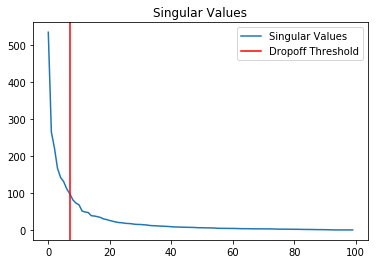

In [4]:
U, s, VT = createSVD(matrix)
plt.plot(s)
plt.title("Singular Values")
k = 8
plt.axvline(x=k-1, color='r')
plt.gca().legend(('Singular Values','Dropoff Threshold'))

##### Truncate SVD  and calculate kmeans based on dropoff:
To create produce topic representatoins, we truncated the matrices from the SVD based on our dropoff $k$. Our matrices took on the form:
$$
M_{n,k} = U_{n,k} \Sigma_{k,k} V^{T}_{p,k}
$$
For kmeans we used sklearn's implementation and set the number of topics to $k$. We use a fixed random seed for reproducability and consistency while evaulating our results. Our input into the kmeans model is the $M$ matrix, where each row is an event and each column is the frequency of a particular word in vocab.

In [5]:
U_, s_, VT_ = truncateSVD(U, s, VT, k=k)
kmeans = KMeans(n_clusters=k, random_state=2).fit(matrix)

##### Generate topic predictions from SVD and kmeans:
The SVD provides predictions based on the weights associated with each row in the $U$ matrix. Each $i$ element represents the weight with respect to the $i$ topic. The topic which has the highest weight is selected for each row as the predicted topic for that row.

For kmeans, the predictions are based on the same $M$ matrix used to train the kmeans model. Both will return a list of predicted topics that range from 0 to $k-1$. The two charts show the events mapped to predicted topics for both SVD and kmeans. The red bars indicate when the data shifted from one participant to the next. So directly after a red bar, a new participant has started their work.

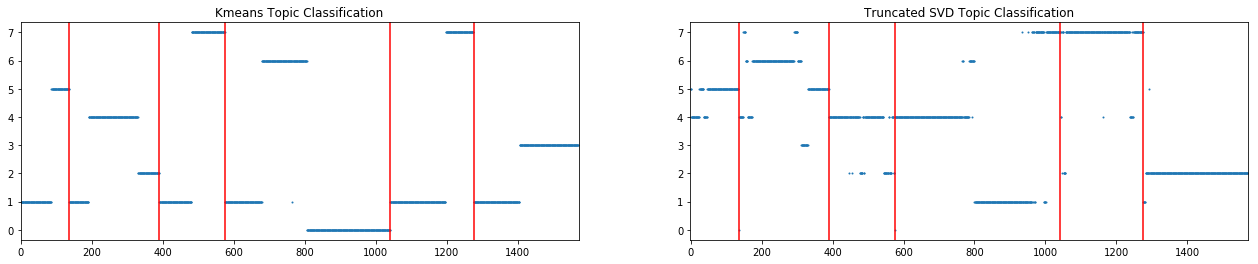

In [6]:
kmeans_predictions = kmeans.predict(matrix)
SVD_predictions = [np.argmax(x) for x in U_]
plotTopicsBetweenModels(SVD_predictions,kmeans_predictions,participants)

##### Information related to each topic:
Once we made the topic predictions, characteristics of each topic could be observed and compared between one another. The most common words and the events for each participant in a cluster are collected to aid evaluation.

In [7]:
print("Most common words in each cluster:")
SVD_common_words = commonClusterWords(SVD_predictions,documents,k)
kmeans_common_words = commonClusterWords(kmeans_predictions,documents,k)
for cluster in zip(range(k),SVD_common_words,kmeans_common_words):
    print("SVD    cluster "+str(cluster[0])+": " + ", ".join(cluster[1]))
    print("Kmeans cluster "+str(cluster[0])+": " + ", ".join(cluster[2]))
    print()
    
print("Count of Participant events in each cluster in the form {<Participant ID:<Count>}:")
SVD_cluster_participants = mapParticipants(SVD_predictions,k,len(documents))
kmeans_cluster_participants = mapParticipants(kmeans_predictions,k,len(documents))
for cluster in zip(range(k),SVD_cluster_participants,kmeans_cluster_participants):
    print("SVD    cluster "+str(cluster[0])+": ", cluster[1])
    print("Kmeans cluster "+str(cluster[0])+": ", cluster[2])
    print()

Most common words in each cluster:
SVD    cluster 0: 
Kmeans cluster 0: Car, Color, Controller, Coord, Event, Key, View, awt, setColor, swing

SVD    cluster 1: Car, Color, Controller, Coord, Event, Key, System, View, awt, swing
Kmeans cluster 1: Car, EXIT, Frame, Graphics, Menu, Panel, String, add, awt, swing

SVD    cluster 2: Car, Event, Frame, Key, Offset, awt, height, width, x, y
Kmeans cluster 2: Event, Key, Rectangle, Square, Square2, Wheel1, Wheel2, awt, getKeyCode, refresh

SVD    cluster 3: Double, Ellipse2, Event, List, Rectangle, Square, Wheel1, Wheel2, awt, event
Kmeans cluster 3: Car, Event, Key, Offset, VK, awt, height, width, x, y

SVD    cluster 4: Car, Color, Event, Frame, Key, Main, Panel, VK, awt, swing
Kmeans cluster 4: Color, Dimension, Double, Ellipse2, List, Rectangle, Square, add, awt, fill

SVD    cluster 5: Color, Left, Point, Square, Square2, Wheel1, Wheel2, add, awt, swing
Kmeans cluster 5: Graphics, Left, Point, Right, Shape, Wheel, add, awt, getX, getY

S

##### Finding Influential words from SVD
The SVD also provides us with information regarding the words. The $V^T$ matrix contains weights of every word in the vocab for the $k$ topics. Choosing the high weights, we can retrieve the words that should be most influential for a particular topic. The dimensionality of each word vector can also be reduced to display them. Using sklearn's TSNE, we can reduce the columns of $V^T$ from $k$ to 2. Plotting these reduced vectors can visually indicate which words are similar if there are spatial close to each other.

SVD cluster 0:  Obj, Iterator, Path, JLabel, Shape, Wheel, Body, Squares, MouseAdapter, Ellipse2D

SVD cluster 1:  Coord, Car, Controller, View, Holder, Bag, Grid, System, Observable, Constraints

SVD cluster 2:  Key, Offset, VK, Event, Frame, Listener, Show, And, Call, Code

SVD cluster 3:  Wheel1, Wheel2, Event, VK, Square, Key, Square2, Coord, Controller, Bus

SVD cluster 4:  Frame, Event, VK, Call, Controller, Main, Point, Key, Label, Window

SVD cluster 5:  Point, Left, Wheel1, Wheel2, Square, Square2, Right, Shape, Wheel, Body

SVD cluster 6:  Event, Rectangle, Point, VK, Key, Left, Mouse, System, List, Call

SVD cluster 7:  Coord, Call, Event, Window, Observable, Mouse, Menu, Observers, VK, Observer



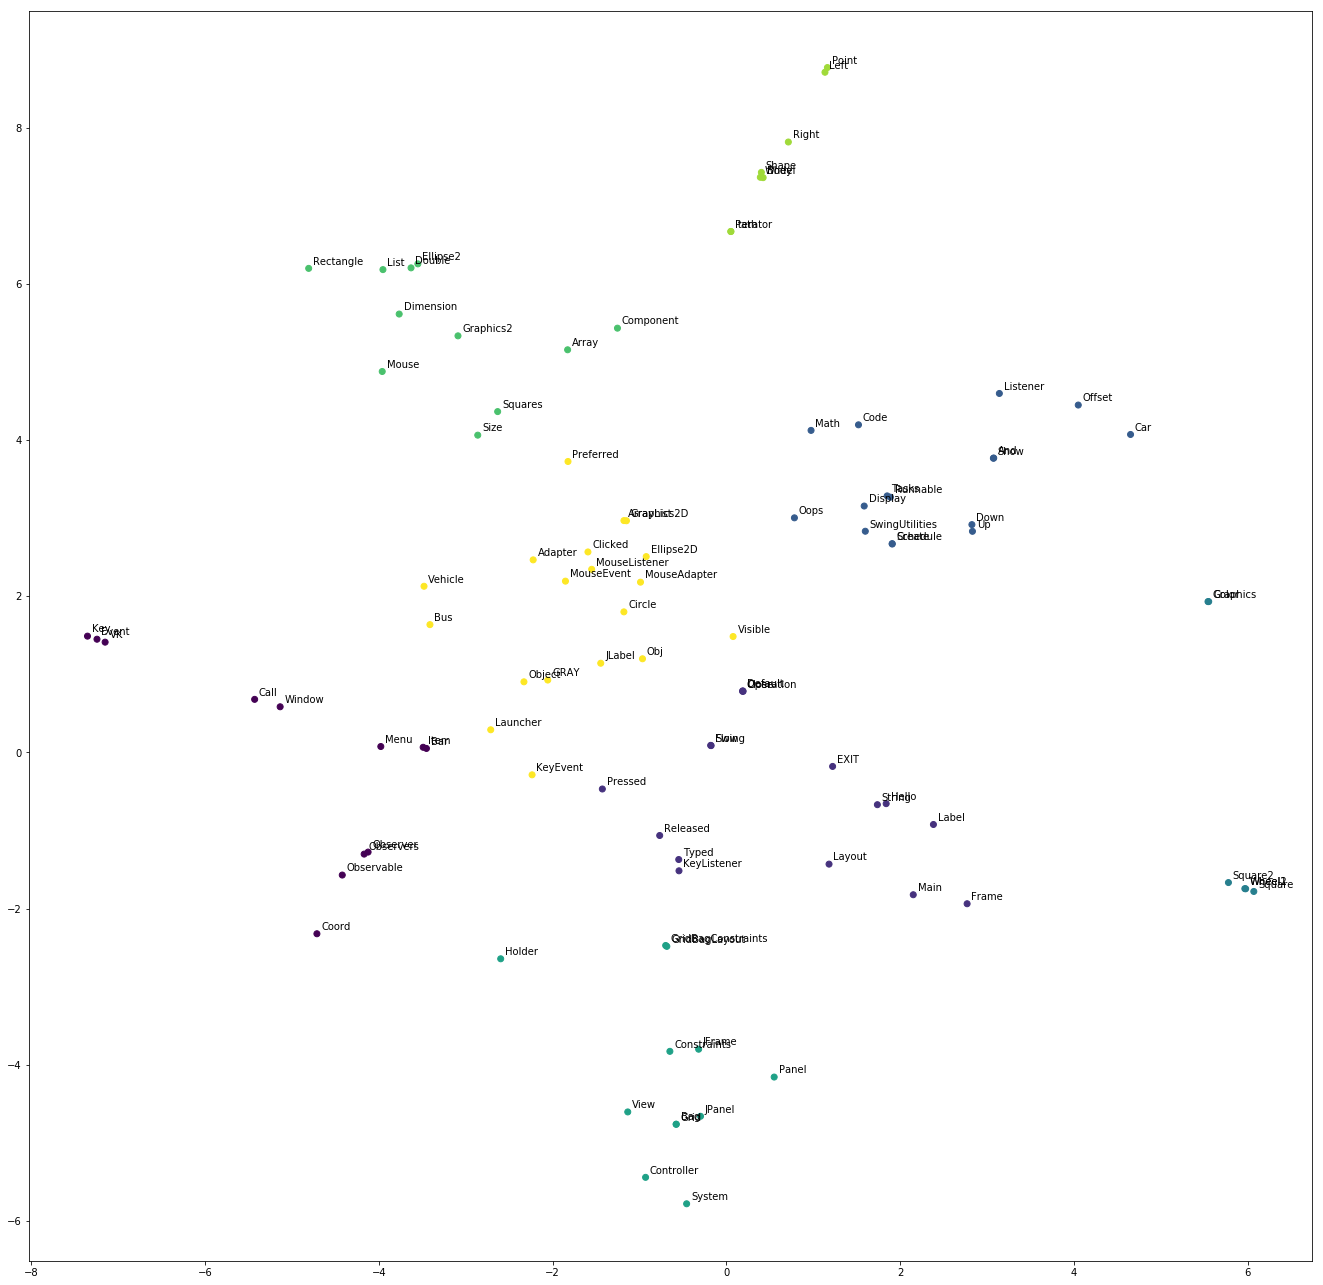

In [8]:
import numpy as np
from sklearn.manifold import TSNE
for i in zip(range(len(VT_)),influentialClusterWords(VT_,vocab,10)):
    print("SVD cluster "+str(i[0])+": ", ", ".join(i[1]))
    print()
VT_embedded = TSNE(n_components=2, random_state=3).fit_transform(np.transpose(VT_))
clusters = KMeans(n_clusters=k, random_state=3)
clusters.fit(VT_embedded)
plt.figure(figsize=(23,23))
plt.scatter(VT_embedded[:,0],VT_embedded[:,1],c=clusters.labels_)
for i, txt in enumerate(list(dict((v,k) for k,v in vocab.items()).values())):
    plt.annotate(txt, (VT_embedded[i,0], VT_embedded[i,1]),(VT_embedded[i,0]+0.05, VT_embedded[i,1]+0.05))

### Single Participant

##### Run preprocessing: 

In [9]:
#arguements
filenumbers = [19] # single particpant 19
fileprefix='hermes-test-'
filesuffix='.txt'
remove_non_class_method = True

#convert each data into events and append to vocab
all_data = []
participants = []
for num in filenumbers:
    filename = fileprefix+str(num)+filesuffix
    all_data.append(readData(filename,remove_non_class_method))
    participants.append(num)

counts, vocab = createVocab(all_data,vocab_length=100)
matrix, documents, participants = createMatrix(all_data, vocab)

##### Calculate SVD to determine dropoff: 

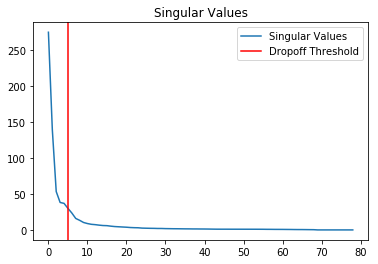

In [10]:
U, s, VT = createSVD(matrix)
plt.plot(s)
plt.title("Singular Values")
k = 6
plt.axvline(x=k-1, color='r')
plt.gca().legend(('Singular Values','Dropoff Threshold'))

##### Truncate SVD based  and calculate kmeans based on dropoff:

In [11]:
U_, s_, VT_ = truncateSVD(U, s, VT, k=k)
kmeans = KMeans(n_clusters=k, random_state=3).fit(matrix)

##### Generate topic predictions from SVD and kmeans:

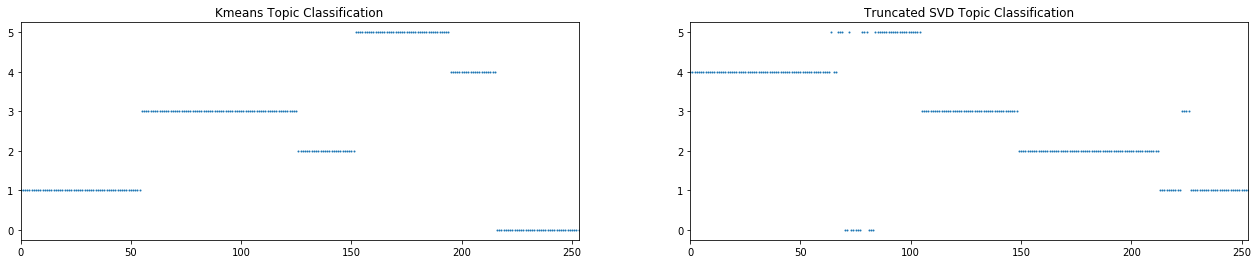

In [12]:
kmeans_predictions = kmeans.predict(matrix)
SVD_predictions = [np.argmax(x) for x in U_]
plotTopicsBetweenModels(SVD_predictions,kmeans_predictions,participants)

##### Information related to each topic:

In [13]:
print("Most common words in each cluster:")
SVD_common_words = commonClusterWords(SVD_predictions,documents,k)
kmeans_common_words = commonClusterWords(kmeans_predictions,documents,k)
for cluster in zip(range(k),SVD_common_words,kmeans_common_words):
    print("SVD    cluster "+str(cluster[0])+": " + ", ".join(cluster[1]))
    print("Kmeans cluster "+str(cluster[0])+": " + ", ".join(cluster[2]))
    print()
    
print("Count of Participant events in each cluster:")
SVD_cluster_participants = mapParticipants(SVD_predictions,k,len(documents))
kmeans_cluster_participants = mapParticipants(kmeans_predictions,k,len(documents))
for cluster in zip(range(k),SVD_cluster_participants,kmeans_cluster_participants):
    print("SVD    cluster "+str(cluster[0])+": ", cluster[1])
    print("Kmeans cluster "+str(cluster[0])+": ", cluster[2])
    print()

Most common words in each cluster:
SVD    cluster 0: Color, Dimension, Event, Graphics, Graphics2, List, Mouse, Rectangle, awt, fill
Kmeans cluster 0: Event, Key, Rectangle, Square, Square2, Wheel1, Wheel2, awt, getKeyCode, refresh

SVD    cluster 1: Event, Key, Rectangle, Square, Square2, Wheel1, Wheel2, awt, getKeyCode, refresh
Kmeans cluster 1: Array, Frame, JFrame, List, Obj, Rectangle, String, awt, swing, util

SVD    cluster 2: Double, Ellipse2, Event, List, Rectangle, Square, Wheel1, Wheel2, awt, event
Kmeans cluster 2: Color, Dimension, Double, Ellipse2, List, Rectangle, Vehicle, add, awt, event

SVD    cluster 3: Color, Dimension, Double, Ellipse2, List, Rectangle, add, awt, event, fill
Kmeans cluster 3: Color, Dimension, Double, Ellipse2, Graphics2, List, Mouse, Rectangle, awt, fill

SVD    cluster 4: Dimension, Frame, Graphics2, List, Obj, Rectangle, Squares, awt, swing, util
Kmeans cluster 4: Event, Key, List, Rectangle, Square, Wheel1, Wheel2, awt, event, refresh

SVD    c

##### Finding Influential words from SVD

SVD cluster 0:  Ra, My, E, D, Ellipse2d, Dou, Do, Doiub, Ket, Kety

SVD cluster 1:  Wheel1, Wheel2, Square2, Square, Key, VK, Event, Bus, Vehicle, KeyEvent

SVD cluster 2:  Square, Double, Ellipse2, Vehicle, Adapter, List, Circle, Typed, MouseAdapter, Wheel1

SVD cluster 3:  Square2, Ellipse2, Double, Bus, Vehicle, List, Color, Circle, MouseAdapter, Visible

SVD cluster 4:  Obj, Rectangle, Frame, Squares, Square, Panel, Wheel2, String, JFrame, Wheel1

SVD cluster 5:  Squares, Dimension, Graphics2, Square, Size, Graphics, Component, Preferred, Visible, Color



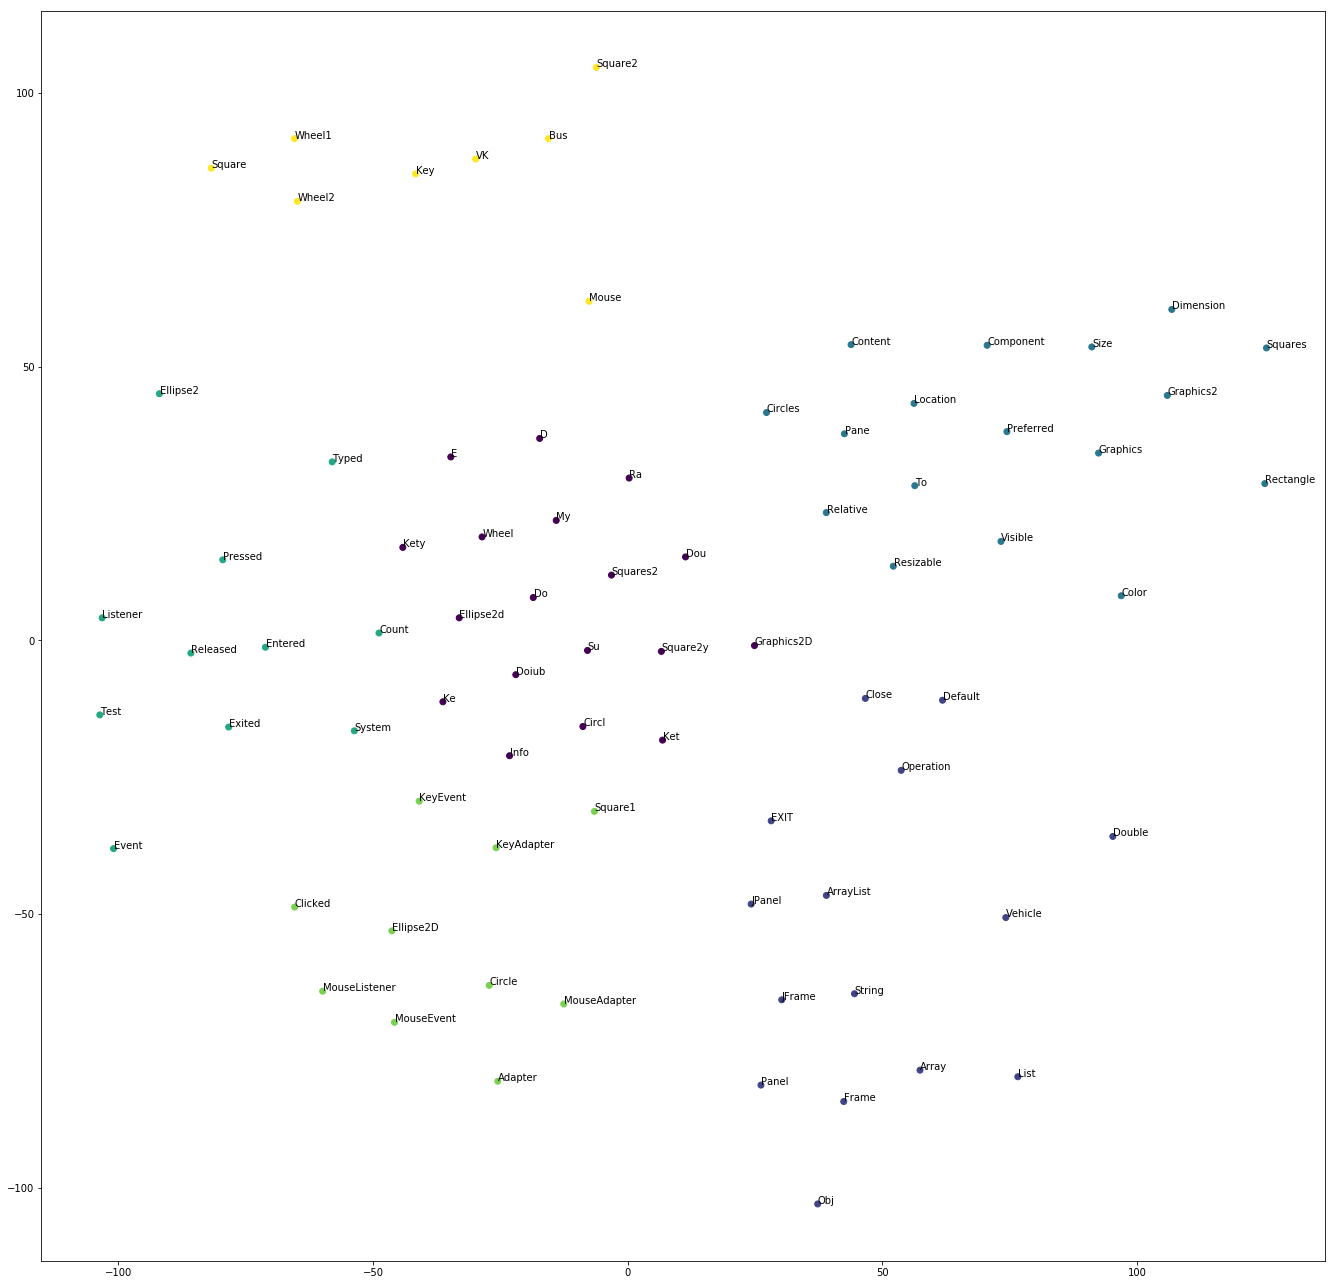

In [14]:
import numpy as np
from sklearn.manifold import TSNE
for i in zip(range(len(VT_)),influentialClusterWords(VT_,vocab,10)):
    print("SVD cluster "+str(i[0])+": ", ", ".join(i[1]))
    print()
VT_embedded = TSNE(n_components=2, random_state=3).fit_transform(np.transpose(VT_))
clusters = KMeans(n_clusters=k, random_state=3)
clusters.fit(VT_embedded)
plt.figure(figsize=(23,23))
plt.scatter(VT_embedded[:,0],VT_embedded[:,1],c=clusters.labels_)
for i, txt in enumerate(list(dict((v,k) for k,v in vocab.items()).values())):
    plt.annotate(txt, (VT_embedded[i,0], VT_embedded[i,1]),(VT_embedded[i,0]+0.05, VT_embedded[i,1]+0.05))

# Evaluation <a name="eval"></a>

In the full-log participants' results, the plot of the singular values of matrix Sigma is shown.  It shows that there is a steep dropoff corresponding with approximately 12 clusters or topics.  This cutoff is displayed with a vertical red line.  After determining the number of topics by using the singular value dropoff in the SVD, we clustered based on a k-means clustering algorithm and also by using the truncated left singular values in the decomposition.  We set the k equal to the number of topics to ensure that the results of the k-means and SVD assignments were as similar as possible.  For the full-log participants, 12 topics seemed to make the most sense.  At first glance, our results were lack-luster.  Most of the clusters were filled by a single participant's data.  This indicated that the algorithm was good at clustering all of a participants document states together, which makes sense, but does not really benefit our research goals.  Upon further consideration, however, it becomes apparent that the algorithm was actually still doing something quite useful for us.  

Looking at the k-means topic classification and truncated SVD topic classification plots, the algorithm is clearly classifying sequential document states into clusters.  This means that as the participant develops this code, the algorithm notices a change in vocabulary and correlates it with a change in topic.  Intuitively this seems obvious that tasks would change only after relatively long sequences of similar document states and that they would be clustered together since they use similar vocabulary, but the results are pleasing.  As a specific example, in the k-means plot, the third participant, participant 21, shows two distinct clusters.  The first cluster is interesting because it is the same across all participants because it is the topic that all participants begin with.  They have no code and then they paint a single shape first, task 1.  The most common words for this kmeans cluster are [Car, Color, EXIT, Frame, Graphics, Offset, Panel, String, awt, swing] which make sense because the participant imports the swing and awt libraries and begins creating a Panel and Frame for painting the shape.  The second cluster shows the jump from painting the shape to task 2 when the participant starts to use key listeners to move the shape in the frame.  The most common words for this kmeans cluster are [Car, Color, Event, Frame, Key, Main, Offset, awt, event, swing].  These also make sense because we start seeing the words Key and Event much more frequently.  

The kmeans had much more clearly defined clusters than the SVD clustering method we used, but even in the truncated SVD clustering plot you can see that document states for the most part are clustered in chronological sequences.  There was definitely more noise with the assignment as you see points jump in the middle of the longer sequences, but overall it was not terrible.  If we look at participant 21 again, there are now 3 significant clusters instead of 2.  The first two, 4 and 9, both correspond to starting states for all the document states instead of a single cluster for all documents to start it.  The most common words for them are [Color, Controller, Event, Frame, Key, Panel, awt, c, setSize, swing] and [Car, Color, Coord, Event, Frame, Key, Panel, VK, awt, swing] respectively, which are not that different.  The last cluster was cluster 8, and the most common words for it were [Car, Event, Frame, Key, Label, Main, VK, awt, getKeyCode, swing].  These show the change to task 2 with Keys and Events as well, so the results are similar.  

The most important thing the full-log participant's results showed us was that the clustering based on word counts in a document of code does work well for differentiating topics within a single user's document state.  For this reason, we pursued the clustering on individual participant's data instead of using all participants' data to see what the results would be.

Not surprisingly, the results above show a nice partitioning on topics within a single participants data.  For the purposes of having a complete codebase to display, we chose participant 19's file to use in the results section, but any participant would have been acceptable.  The cutoff plot for participant 19 alone shows that there was a significant drop in the number of topics.  This made sense because we would not expect a single participant's document to show the same number of topics as 6 participants.  If we look at the kmeans and truncated SVD plots again, we see that the documents are still being assigned to clusters in long chains or sequential rows/states, which is what we expected.  The first cluster, cluster 1, is mainly setting up the code, importing swing and awt, and painting the first car object using JFrames.  The second cluster, cluster 3, was actually implementing the painting method, choosing the color, and filling the shapes on the screen.  The third cluster, cluster 2, corresponded to beginning to add the key events and such.  The fourth and fifth clusters, clusters 5 and 4 respectively, are nearly the same, they only indicate the introduction of a second Ellipses object which the participant decided to add.  The interesting point here is that the truncated SVD plot merges those two clusters together because, as we saw, they are not very different.  Finally, the sixth cluster, cluster 0, directly correlated with task 3, making a two story bus instead of a car.

The truncated SVD actually seemed better with the single participant's data as well.  The clusters more closely aligned with those of the k-means, which was interesting.  In the plot below, the two classifiers are plotted together, and it illustrates how similar the classifications were.  There was a significant amount of overlap between the clusters, which means that they were somewhat distinct topics.

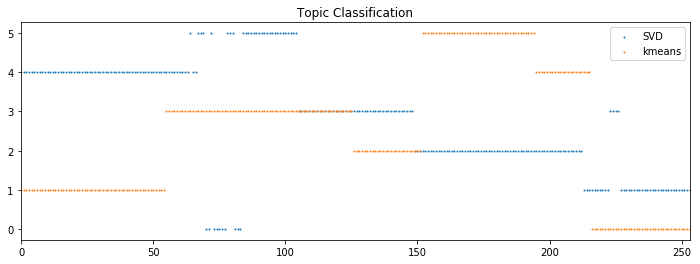

In [15]:
plotTopicsBetweenModels(SVD_predictions,kmeans_predictions,participants, sameGraph=True)


Lastly, we mapped the most influential words for each classification into lower dimensions so that they could be plotted and important words for each cluster visualized.  These figures can be seen above in the results with a more in depth explanation of how they were created.  For example, the upper left cluster has significant words like Bus, Square2, Mouse, Key, etc. which indicate that both the mouse and key listener are already implemented and the participant has moved on to working on task 3 with the doubling of the car's size.  This does not directly benefit the clustering we have done so far, but in the future we could then cluster based on these specific words and, theoretically, get better results.

# Conclusion <a name="conclusion"></a>

We observed that the classification for multiple participants based off of word counts did not distinctly separate tasks over all participants, but it did classify somewhat accurately the tasks of individual participants after having clustered the participants.  This did, however, lead us in the direction of classifying only on the single participant's data.  The performance for single participants, while difficulty to evaluate because of the nature of unsupervised learning algorithms, made sense and seemed to do well within the scope of this project.  

In the future, we would like to store the classifications for single users using the tools we already have in place and then label the clusters using the most significant words we derived using the right singular values.  Then if another user at some point has a cluster with similar significant words we could perhaps make the inference that they are working on a similar task. Another approach would be to simply cluster on the significant words as we showed using the tsne library.  

# Appendix <a name="appendix"></a>

#### [Event parsing tool](https://github.com/npersson001/Multiclassification-Of-Tasks-With-Topics-Modeling) <a name="tool"></a>
